## Starting with inital Wuhan data

In [1]:
import numpy as np
from statsmodels.api import OLS
from statsmodels.tools.tools import add_constant
from matplotlib import pyplot as plt

In [2]:
confirmed = np.array([45, 62, 121, 198, 291, 440, 571, 830, 1287, 1975,
                      2744, 4515, 5974, 7711, 9692, 11791, 14380, 17205,
                      20438, 24324, 28018, 31161, 34546, 37198,])

## Exponential function with ordinary least squares.

In [3]:
x = np.arange(len(confirmed))
x = add_constant(x)

In [4]:
model = OLS(np.log(confirmed[:14]), x[:14]) # First two weeks
# model = OLS(np.log(confirmed), x) # Full data

In [5]:
result = model.fit()

In [6]:
result.summary()

/Users/gregorius/miniconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     2488.
Date:                Mon, 23 Mar 2020   Prob (F-statistic):           2.77e-15
Time:                        19:35:27   Log-Likelihood:                 10.843
No. Observations:                  14   AIC:                            -17.69
Df Residuals:                      12   BIC:                            -16.41
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.9515      0.061     64.683      0.000       3.818       4.085
x1             0.3984      0.008     49.878      0.000       0.381       0.416
==============================================================================
Omnibus:                        1.291   Durbin-Watson:                   0.917
Prob(Omnibus):                  0.524   Jarque-Bera (JB):                1.028
Skew:                          -0.580   Prob(JB):                        0.598
Kurtosis:                       2.356   Cond. No.                         14.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

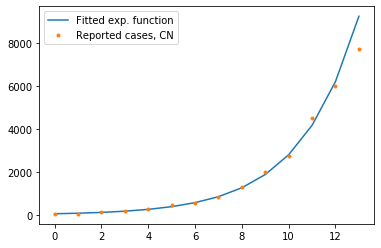

In [7]:
plt.plot(
    np.exp(result.predict(x[:14])),
    label="Fitted exp. function"      
)
plt.plot(confirmed[:14], ".", label="Reported cases, CN")
plt.legend()
plt.show()

In [8]:
world_population = 7763252653
days = 0
infected = confirmed[14]
while infected < world_population:
    days += 1
    infected = np.exp(result.predict([1, 13 + days]))[0]
print(f"Number of days until whole world is infected: {days}")

Number of days until whole world is infected: 35


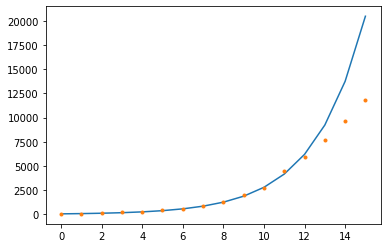

In [9]:
plt.plot(np.exp(result.predict(x[:16])))
plt.plot(confirmed[:16], ".")
plt.show()

## Logistic function fit

\begin{equation}
    f(x; a, b, c, d) = \frac{a}{1 + \exp({-c (x-d)})} + b
\end{equation}

In [10]:
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
logistic_function = lambda x, a, b, c, d: \
    a / (1 + np.exp(-c * (x - d))) + b

In [11]:
confirmed = np.array(confirmed)
x = x[:, 1]

In [12]:
(a_, b_, c_, d_), _ = curve_fit(logistic_function, x, confirmed)

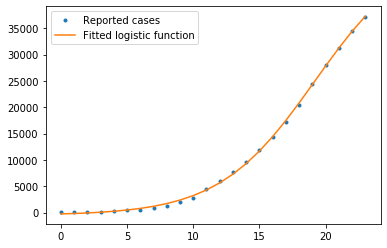

In [13]:
def plot_logistic_fit(confirmed, logistic_params):
    a_, b_, c_, d_ = logistic_params
    x = np.arange(0, len(confirmed))
    plt.plot(x, confirmed, ".", label="Reported cases")
    confirmed_pred = logistic_function(x, a_, b_, c_, d_)
    plt.plot(x, confirmed_pred, label="Fitted logistic function")
    plt.legend()
    plt.show()
    return confirmed_pred
confirmed_pred = plot_logistic_fit(confirmed, (a_, b_, c_, d_))

In [14]:
r2_score(confirmed, confirmed_pred)

0.999500185228235

In [15]:
def plateau(confirmed, logistic_params, diff=10):
    a_, b_, c_, d_ = logistic_params 
    confirmed_now = confirmed[-1]
    confirmed_then = confirmed[-2]
    days = 0
    now = x[-1]
    while confirmed_now - confirmed_then > diff:
        days += 1
        confirmed_then = confirmed_now
        confirmed_now = logistic_function(
            now + days,
            a_,
            b_,
            c_,
            d_,
        )
    return days, confirmed_now
days, confirmed_now = plateau(confirmed, (a_, b_, c_, d_))
print(f"In {days} days the number of infected people will plateau at {int(confirmed_now)}")

In 23 days the number of infected people will plateau at 50430


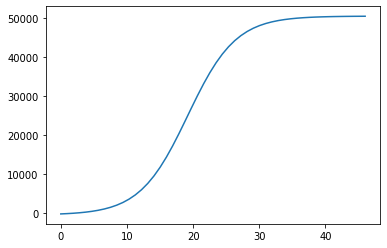

In [16]:
x_ = np.linspace(0, x[-1] + days)
plt.plot(
    x_,
    logistic_function(x_, a_, b_, c_, d_)
)
plt.show()

## Italy data, logistic fit

In [25]:
cases_italy = np.array([
    20,
    79,
    150,
    229,
    322,
    400,
    650,
    888,
    1128,
    1694,
    2036,
    2502,
    3089,
    3858,
    4636,
    5883,
    7375,
    9172,
    10149,
    12462,
    15113,
    17660,
    21157,
    24747,
    27980,
    31506,
    35713,
    41035,
    47021,
    53578,
    59138,
    63928,
])

In [26]:
x = np.arange(0, len(cases_italy))
params, _ = curve_fit(logistic_function, x, cases_italy)

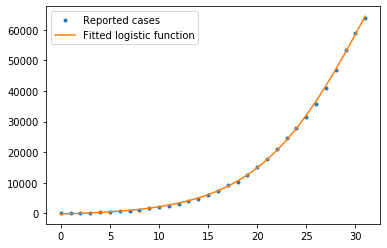

In [19]:
italy_pred = plot_logistic_fit(cases_italy, params)

In [20]:
r2_score(cases_italy, italy_pred)

0.9995632489506111

In [27]:
diff = 100
days, cases = plateau(cases_italy, params, diff=diff)
print(f"{days} days until growth is lower than {diff} per day")
print(f"The total cases will be at {int(cases)}")

31 days until growth is lower than 100 per day
The total cases will be at 130475


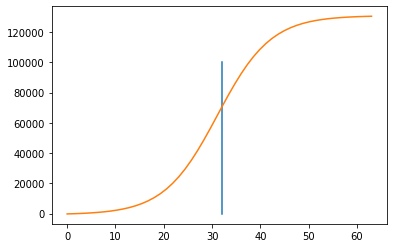

In [30]:
x = np.linspace(0, len(cases_italy) + 31)
y = logistic_function(x, *params)
plt.plot([len(cases_italy), len(cases_italy)], [0, 100000])
plt.plot(x, y)
plt.show()